In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model, text_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPool2D, Dropout, Embedding, GlobalAveragePooling1D, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, BinaryCrossentropy

import os
import re
import shutil
import string
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print('tensorflow version is {}'.format(tf.__version__))

tensorflow version is 2.9.0


In [3]:
file='stack_overflow_16k'
url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

In [4]:
# # 뭔가 이상함, cache_subdir=file로 한 후 '' 해야 directory 구조가 원하는 대로 됨
dataset = tf.keras.utils.get_file(file, origin=url, untar=True, cache_dir='.' , cache_subdir=file)

In [5]:
# # 뭔가 이상함, cache_subdir=file로 한 후 '' 해야 directory 구조가 원하는 대로 됨
dataset = tf.keras.utils.get_file(file, origin=url, untar=True, cache_dir='.' , cache_subdir='')

In [6]:
dataset

'./stack_overflow_16k'

In [7]:
os.listdir(dataset)

['test', 'stack_overflow_16k.tar.gz', 'README.md', 'train']

In [8]:
train_dir = os.path.join(dataset, 'train')

In [9]:
test_dir = os.path.join(dataset, 'test')

In [10]:
train_dir

'./stack_overflow_16k/train'

In [11]:
seed = 111
batch_size = 32

In [12]:
raw_train = text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2, subset='training', seed=seed)
raw_val = text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2, subset='validation', seed=seed)
raw_test = text_dataset_from_directory(
    test_dir, batch_size=batch_size)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Metal device set to: Apple M1


2022-06-17 07:32:58.330762: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-17 07:32:58.331057: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [13]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [15]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [16]:
text_batch, label_batch = next(iter(raw_train))

2022-06-17 07:32:58.975032: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [17]:
first_review = text_batch[0]
first_label = label_batch[0]
print('first riview: ', first_review.numpy())
print('first label: ', raw_train.class_names[first_label])

first riview:  b'"comparing 2 int arrays can anyone tell me whats wrong in this method and why it gives a nullpointerexception ?..public boolean check(){..    scanner scan = new scanner(system.in);..    int[] arr1 = new int []{1,2,3};.    int[] arr2 = new int[]{};..    for(int i = 0;i&lt;arr1.length;i++).    {.        system.out.println(""enter numbers to check"");.        arr2[i] = scan.nextint();.    }..    if(arr1 == arr2).        return true;..    return false;.}"\n'
first label:  java


In [18]:
text_for_word_tabel = raw_train.map(lambda x, y: x)
vectorize_layer.adapt(text_for_word_tabel)

2022-06-17 07:32:59.051617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [19]:
print(vectorize_text(first_review, first_label))

(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1031,   59,   29,  657,   34,  289,  414,   74,  476,  149,    7,
          13,   66,    8,  109,   10,  400,    5, 1790,   19,  264,  184,
         245, 1267,   15,  442,   29,    1,   15,   29, 1118,   29, 5994,
          15,   29,  410,    3,    1,  547,  188,    4,  184,    1, 2154,
           1, 5994,   25,   91,   25,  101,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,  

In [20]:
print('1031 means ', vectorize_layer.get_vocabulary()[1031])
print('5994 means ', vectorize_layer.get_vocabulary()[5994])

1031 means  comparing
5994 means  arr2


In [21]:
train_data = raw_train.map(vectorize_text)
val_data = raw_val.map(vectorize_text)
test_data = raw_test.map(vectorize_text)

In [29]:
embedding_dims =64

model = Sequential([Embedding(max_features + 1, embedding_dims), 
                   Dropout(0.2), 
                   GlobalAveragePooling1D(),
                  Dropout(0.2), 
                  Dense(4, activation='softmax')])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          640064    
                                                                 
 dropout_2 (Dropout)         (None, None, 64)          0         
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 640,324
Trainable params: 640,324
Non-trainable params: 0
________________________________________________

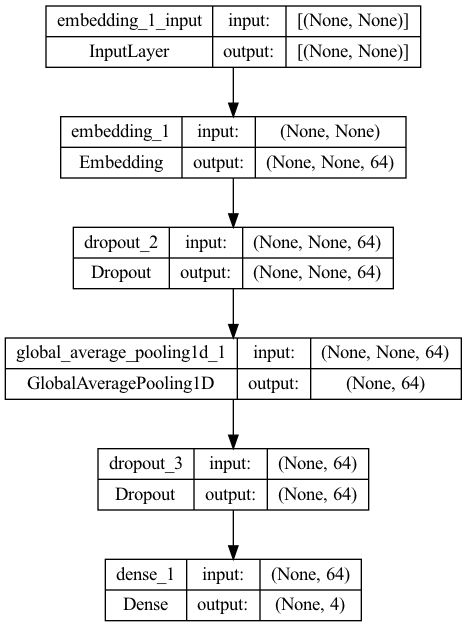

In [30]:
plot_model(model, show_shapes=True)

In [31]:
model.compile(loss='sparse_categorical_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

epochs=50
history = model.fit(train_data, validation_data=val_data, epochs=epochs)

In [26]:
loss, accuracy = model.evaluate(test_data)

print('loss: {}'.format(loss))
print('accuracy: {}'.format(accuracy))

250/250 [==============================] - 1s 5ms/step - loss: 0.5756 - accuracy: 0.7986
loss: 0.5756345391273499
accuracy: 0.7986250519752502


In [27]:
record = history.history

train_loss = record['loss']
train_accuracy = record['accuracy']
val_loss = record['val_loss']
val_accuracy = record['val_accuracy']

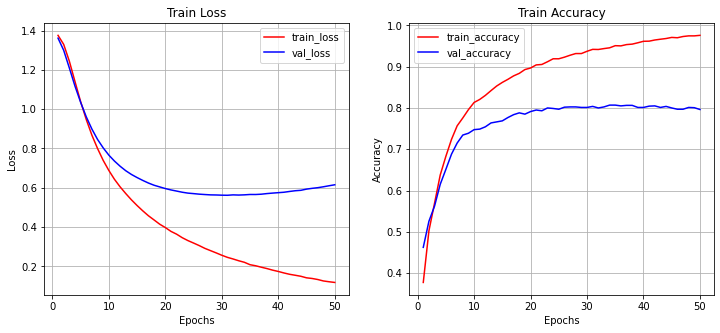

In [28]:
fig = plt.figure(figsize=(12, 5))
epochs = range(1, len(train_loss) + 1)

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, train_loss, color='red', label='train_loss')
ax1.plot(epochs, val_loss, color='blue', label='val_loss')
ax1.set_title('Train Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, train_accuracy, color='red', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='blue', label='val_accuracy')
ax2.set_title('Train Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()